# 1. Data Cleaning + preprocessing

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = 'C:/Users/Vincent/Documents/AI/Datasets/Plant_disease'

# Create a dataset from the directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image, label in dataset.take(1):
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 2 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1]


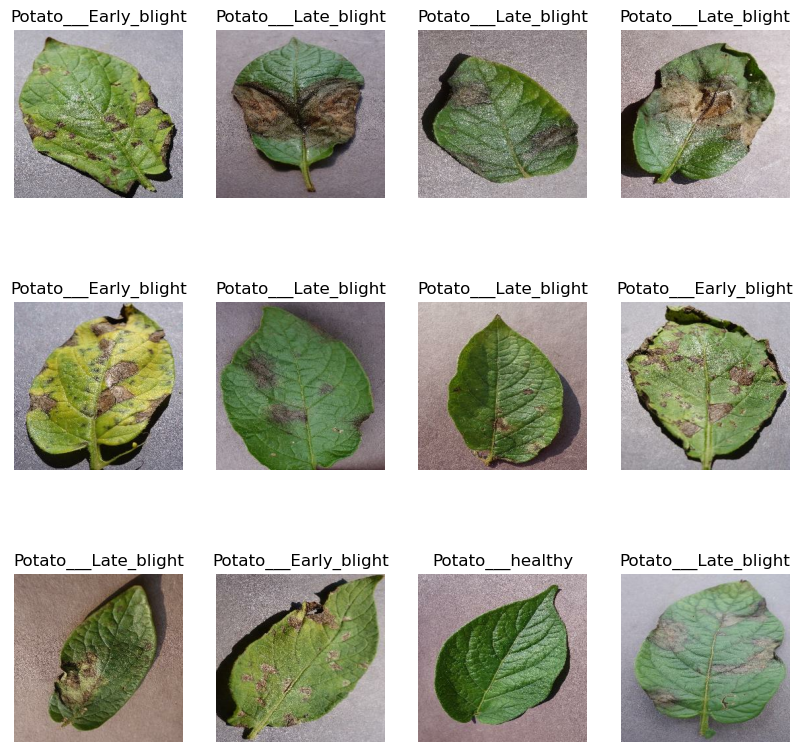

In [8]:
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt

# Assuming you have a list of class names defined as class_names

for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255), # It divides each pixel to a normalized range between 0 and 1.
])

# 2. Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Building a Model

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    # from_logits=False, I am indicating model's output is expected to be probabilities,
    #and the cross-entropy loss will be computed based on these probabilities. 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 200s 3s/step - loss: 0.9210 - accuracy: 0.4954 - val_loss: 0.8787 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 120s 2s/step - loss: 0.7481 - accuracy: 0.6302 - val_loss: 0.6277 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 121s 2s/step - loss: 0.5594 - accuracy: 0.7755 - val_loss: 0.3697 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 120s 2s/step - loss: 0.4205 - accuracy: 0.8218 - val_loss: 0.4695 - val_accuracy: 0.7656
Epoch 5/50
54/54 [==============================] - 120s 2s/step - loss: 0.3347 - accuracy: 0.8571 - val_loss: 0.2673 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 125s 2s/step - loss: 0.2700 - accuracy: 0.8987 - val_loss: 0.2632 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 119s 2s/step - loss: 0.3254 - accuracy: 0.8600 - val_loss: 0.1219 - val_accuracy: 0.9531
Epoch 8/50
54

# On Test Data set

In [20]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 39s 409ms/step - loss: 0.1047 - accuracy: 0.9648


# Score

In [21]:
scores

[0.10474322736263275, 0.96484375]

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.history['loss']

[0.9210048913955688,
 0.7481445670127869,
 0.5593785643577576,
 0.4204820394515991,
 0.3346511721611023,
 0.27000465989112854,
 0.32535842061042786,
 0.2159588485956192,
 0.15753880143165588,
 0.13877490162849426,
 0.13500869274139404,
 0.10696817189455032,
 0.1311395764350891,
 0.09448421746492386,
 0.09884996712207794,
 0.09804368764162064,
 0.07794112712144852,
 0.08689466118812561,
 0.05348048731684685,
 0.07278454303741455,
 0.09104003012180328,
 0.05919878929853439,
 0.10582243651151657,
 0.07441390305757523,
 0.04515780881047249,
 0.0780128762125969,
 0.04216354712843895,
 0.0732412040233612,
 0.061804600059986115,
 0.06633037328720093,
 0.03880687430500984,
 0.028645191341638565,
 0.04863686487078667,
 0.031423717737197876,
 0.03273385390639305,
 0.1100088506937027,
 0.040749430656433105,
 0.0797724723815918,
 0.031866613775491714,
 0.022320948541164398,
 0.052497148513793945,
 0.0505683459341526,
 0.022304093465209007,
 0.028492389246821404,
 0.05023365467786789,
 0.0266933869

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

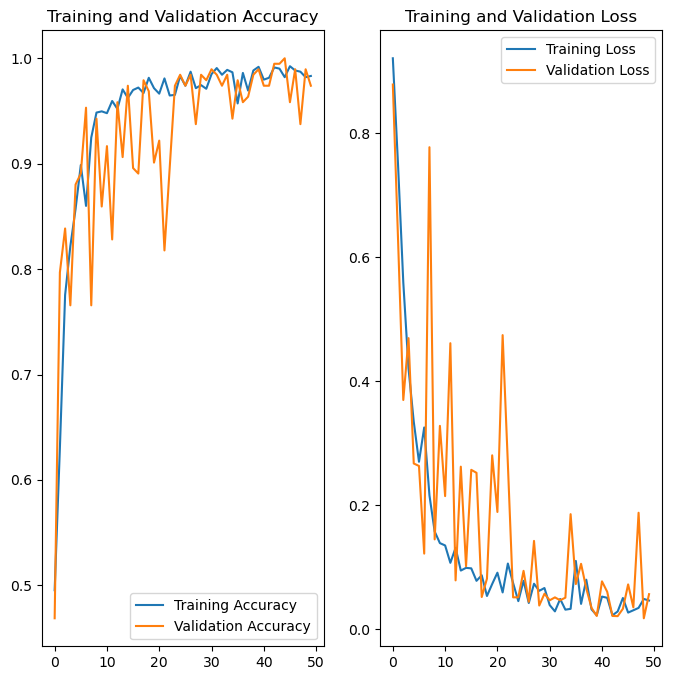

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

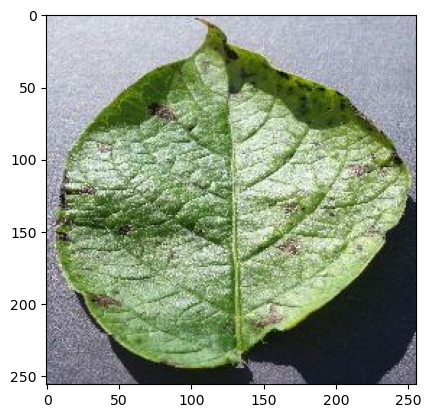

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

# Prediction on a single image

In [29]:
batch_prediction[0]     # probabilities of various label

array([5.5799680e-04, 9.9941766e-01, 2.4323419e-05], dtype=float32)

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 672ms/step
predicted label: Potato___Late_blight


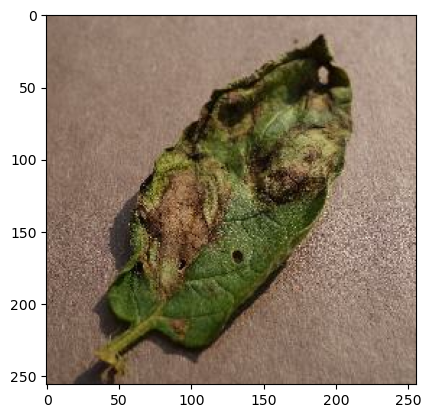

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    plt.imshow(first_image)

# Confidence for multiple images

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


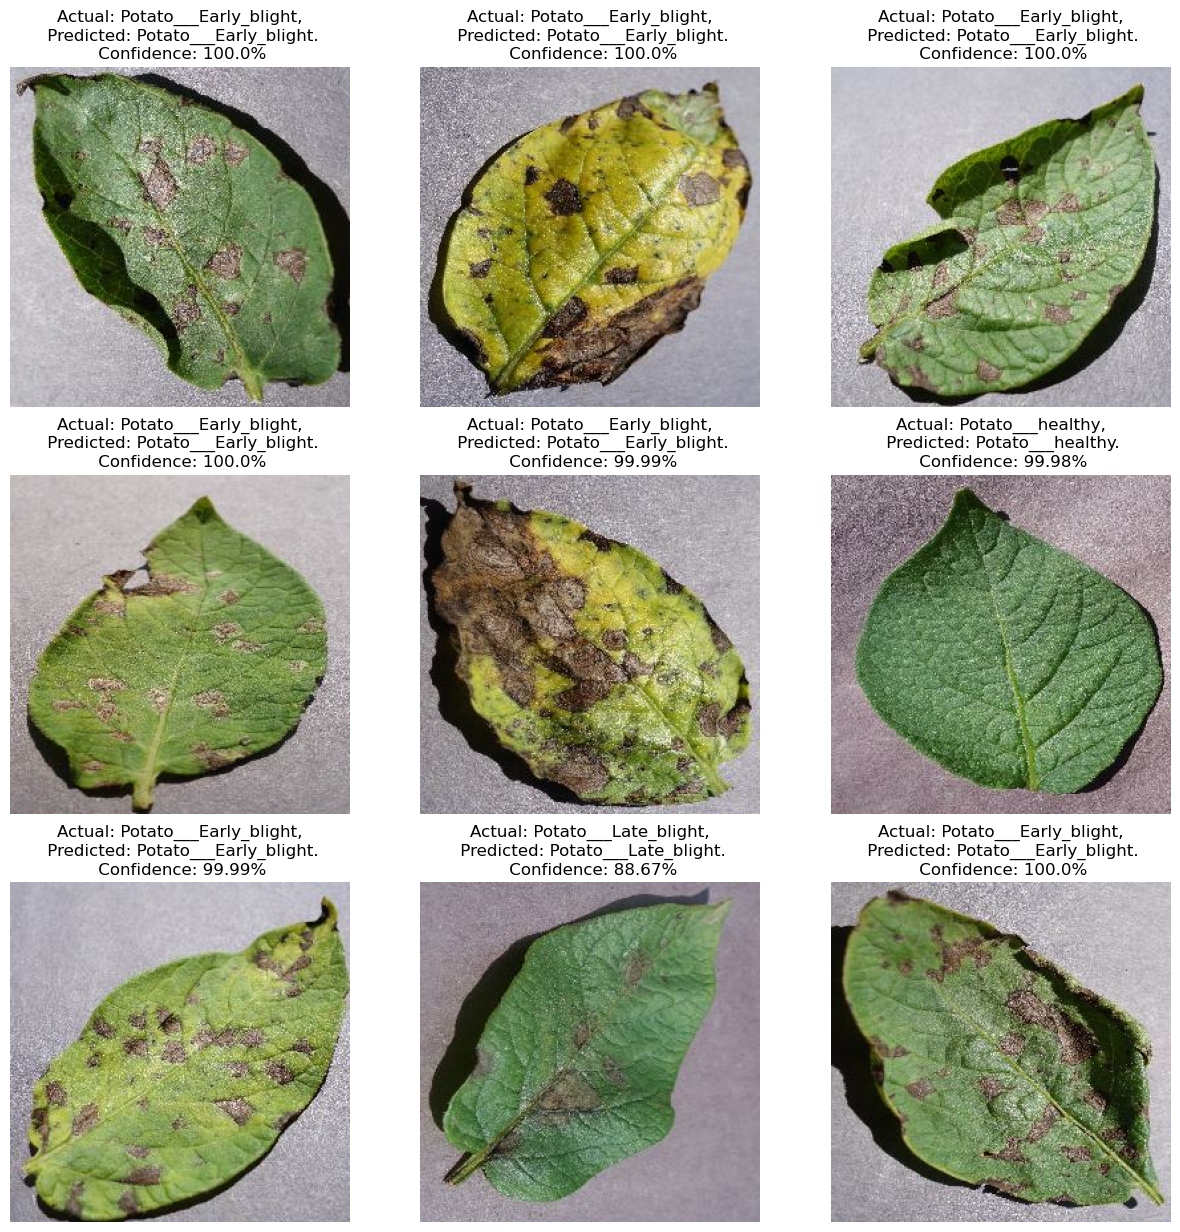

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Ok!! Now model is ready for Deployment